# BG-21: Exoplanets discovered with Transit Photometry and their habitability.

Student number: 24502

Key words: Exoplanets, Transit Method, Photometry, Habitable Zone, Savitzky-Golay, Lombscargle.

### Abstract: 

Exoplanets are planets outside of the Solar System that may posses signs of habitability for human life and be candidates for the next human world. We investigate the use of Transit Photometry on a stellar light curve to discover Exoplanets and their characteristics. By identifying the periodic dips in observed flux as the planets orbit the star, we can extract planetary radii, semi-major axis and habitable zones using Kepler's Laws and Transit analysis. To do this, we normalise a stellar light curve using the Savitzky-Golay flattening method, finding periodicities using the Lombscargle method. From this, we discover 4 exoplanets - 21a, 21b, 21c and 21d. Found periods (days) of 331.6 (±0.022), 210.6 (±0.014), 59.74 (±0.001) and 91.94 (±0.002) respectively. Calculated radii (Jupiter radius) of 1.098 (±0.047), 0.688 (±0.032), 0.288 (±0.013), 0.279 (±0.013) respectively. Finally, calculated semi-major axis (AU) of 0.974 (±0.014), 0.720 (±0.011), 0.311 (±0.004), 0.414 (±0.006) respectively. All figures given to four significant figures. The two larger planets are most likely gas giants synonymous to Jupiter & Saturn. We focus on 21a in particular; residing in the systems habitable zone of, at minimum 0.29, to, at maximum 2.4 AU, depending on calculation method.

### 1. Introduction:

$\textbf{1.1 Exoplanets}$

Exoplanets are defined as planets outside of the Solar System with minimum mass/size on the same scale of planets in our Solar System defined by the IAU.$^{[1]}$ These planets may posses signs of habitability for human life and be candidates for the next human world. The first confirmed detection occurred in 1992, with 4877 confirmed in 3604 planetary systems as of 15 Dec 2021.$^{[2]}$ In ascending order of size, Exoplanets are categorized into 4 types: Super-Earths, Mini-Neptunes, Ice Giants and Gas Giants.


$\textbf{1.2 Exoplanet Detection}$

Many methods are used to detect Exoplanets, such as Radial Velocity, Direct Imaging and Transit - this investigation will use the transit photometry method. This is where the measured lightcurve of a star has periodic dips in luminosity that correlate to the Exoplanet orbiting the star and blocking a portion of it's flux in our line of detection.

The decrease in flux observed is related to the stellar and planetary radii as below.

$$\dfrac{\Delta{}F}{F} = \dfrac{R^2_{planet}}{R^2_{star}}$$

Where $F$ is the baseline flux, $\Delta{F}$ the measured dip in flux, $R_{planet}$ and $R_{star}$ the radii of the planet and star respectively.

Using Kepler's Laws, we can also define the semi-major axis of orbit using the identified period as below.

$$ P^2 = \dfrac{4\pi{}^2}{GM}a^3 \Rightarrow a = {\left(G{M_{Star}}\dfrac{P^2}{4\pi^{2}}\right)}^{1/3} $$

Where $G$ is gravitational constant, $P$ the orbital period of the planet, $a$ the semi-major axis and $M_{star}$ the mass of the star.

We investigate features of the Exoplanets discovered in the system, such as comparisons of the planets metadata to wider populations and the planets orbital synchrony to their star.

$\textbf{1.3 Habitability}$

We will investigate the habitability of the Exoplanets found in this lightcurve and discuss whether their planetary compositions are suitable for human life. The Habitable Zone (HZ) is defined as the region surrounding a star in which water can remain in it's liquid state.

We can calculate this using multiple methods, all providing approximate radii for the HZ. 

The first method we use is calculating the equilibrium temperature, by equating the rate of energy radiated by the planet to the rate of energy absorbed by the planet as below.

$$4\pi{}R^{2}\sigma{}T^{4} = \dfrac{\pi{}R^{2}L_{star}(1-a)}{4\pi{}d^{2}} \Rightarrow d = \sqrt{\dfrac{L_{star}(1-a)}{16\pi{}\sigma{}T^{4}}}$$

Where $a$ is the bond albedo, $T$ is the temperature at distance $d$, $L_{star}$ the stellar luminosity. We test various bond albedos and expected temperature values to find upper and lower limits to the HZ.

The second method uses radii formula derived in Whitmire et al.$^{[3]}$ Approximating the radii of the HZ boundaries by using the stellar luminosity in the expression below to a greater accuracy.

$$ r_{i} = \sqrt{\dfrac{L_{star}}{1.1}}, r_{o} = \sqrt{\dfrac{L_{star}}{0.53}}$$

Where $r_{i}$ and $r_{o}$ denote the inner and outer radii of the HZ boundaries and $L_{star}$ is the stellar luminosity.

$\textbf{1.4 Atmospheric Composition \& Biosignature}$

Finally, we will consider how we would determine the atmospheric composition, to further determine the habitability. We identify the methods that would be investigated in future studies, such as Spectroscopy, Transmission Photometry and thermal phase curves. Identifying key features like the ratio of nitrogen and argon to oxygen that would be needed in sustaining biological life.

### 2. Results - Modelling of Kepler lightcurve

In this section we will look into the modeling of the the Kepler lightcurve. This will be in relation to the code used to analyze the Kepler data. All code is annotated as needed - any ambiguities will be explained outside of the code boxes.

To begin with, all required python modules are imported, astronomical constants and values stored and the base lightcurve plotted.

In [2]:
# Imports

from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import scipy.signal
import math
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from scipy.signal import lombscargle 
from mpl_toolkits.mplot3d import Axes3D

mykepler = '3'

In [194]:
# Astro Values
M_sun = 1.989e30 #kg
R_sun = 696340000 #m
M_J = 1.898e27 #kg
R_J = 69911000 #m
M_E = 5.972e24 #kg
R_E = 6371000 #m
R_E_J = R_E / R_J
G = 6.6743e-11
SFC = 5.67e-8
AU = 1.496e11 #m
ly = 9.46e15 #m
L = 3.828e26 #W

# Host Star Details
M_s = (1.12 * M_sun)
sigmaM_s = (0.05 * M_sun)
R_s = (1.21 * R_sun)
sigmaR_s = (0.05 * R_sun)
R_s_J = R_s / R_J
sigmaR_s_J = sigmaR_s / R_J
T_s = 6031 #K
sigma_T_s = 35
L_s = 0.507 * L
Distance = 2840 * ly

In [323]:
lc = fits.open('Data/Object%slc/kplr%s_1.fits'%(mykepler, mykepler))

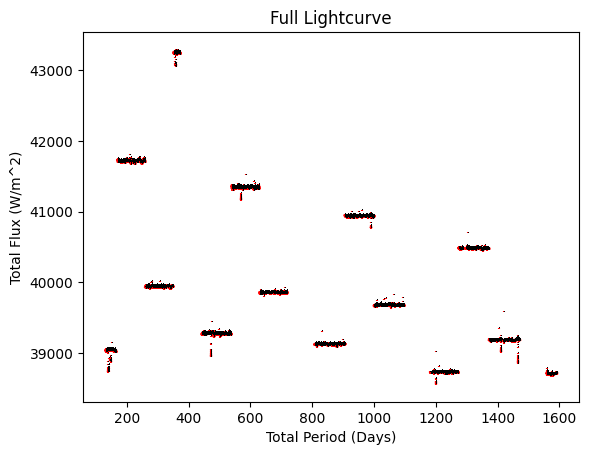

In [324]:
# Kepler 3 Dataset Plotted
for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    
    # Plotting lightcurve with errors
    plt.errorbar(tmptime, tmpflux, tmperror, ls='None', c='red')
    plt.plot(tmptime, tmpflux, ls='None', marker=',', c='black', label='Data')
    plt.title('Full Lightcurve')
    plt.ylabel('Total Flux (W/m^2)')
    plt.xlabel('Total Period (Days)')

**Fig. 1.** *Plot showing the full unaltered kepler lightcurve with the period in days plotted against the total flux in W/m^2*.

$\textbf{2.1 Flattening \& Normalizing the lightcurve}$

From Fig.1. we can see that the Kepler telescope took 14 distinct observation windows. These have varying unnormalized flux due to possibly poor calibration during each measurement window. We execute as three stage process to clean this data to a suitable form. 

First, removing infinities or NANs (not a number values) so that we avoid divisions or operations by undefinable values. Then, we apply a flattening model to normalize the varying flux's into a flat lightcurve. This will let us manipulate the data later on to find periodic dips in flux. Finally, removing flux values 3 standard deviations above the mean value. This ensures we discredit anomalous values that are not relevant to the main light curve. 3 standard deviations was chosen to avoid to balance the information kept versus lost.

Two methods are applied to flatten the curve, the Savitzky-Golay smoothing function and the Median filter. Below, we will investigate the benefits of each at their signal processing & noise reduction ability.

$\textbf{2.1.1 Savitzky-Golay Curve Flattening}$

This smoothing method uses convolution, by fitting successive sub-sets of adjacent data points with a low-degree polynomial using linear least squares.$^{[4]}$ The degree of the fitted polynomial can be chosen between 2 to 6, in the code we have used a cubic (order 3) polynomial. The animation below demonstrates this.
<img src="SVG.gif" style="width: 350px;"/>

**Fig. 2.** *Animation showing the Savitzky-Golay smoothing, the red line indicates local low-degree polynomials being fit to the sub-set of data, with the smoothed values overlayed in circles.$^{[5]}$*.

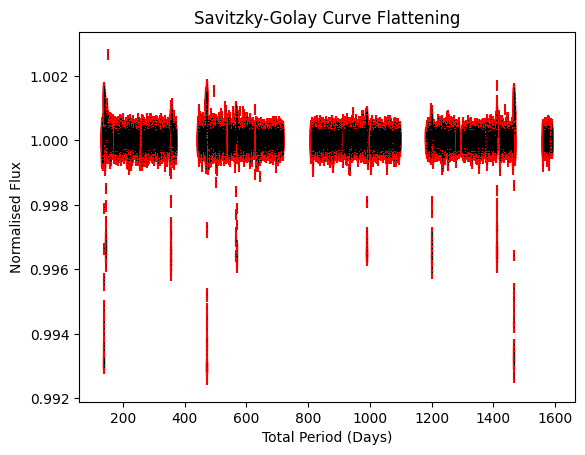

In [325]:
# Savitzky-Golay Method
for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    
    # Removing infinites/zeros
    tmpmask = np.isfinite(tmpflux)
    
    # Applying savitzky-golay with order 3 polynomial
    interp_savgol = savgol_filter(tmpflux[tmpmask], window_length=333, polyorder=3)
    filttime = tmptime[tmpmask]
    filtflux = tmpflux[tmpmask] / interp_savgol
    filterror = tmperror[tmpmask] / interp_savgol
    
    # Removing values 3 standard deviations above 1
    std_dev = np.nanstd(filtflux)
    ymask = (filtflux < (1 + 3*std_dev))
    
    # Masking meta-columns with removed standard deviations    
    time = filttime[ymask]
    flux = filtflux[ymask]
    fluxerror = filterror[ymask]
    
    plt.errorbar(time, flux, fluxerror, ls='None', c='red')
    plt.plot(time, flux, ls='None', marker=',', c='black', label='Data')
    plt.title('Savitzky-Golay Curve Flattening')
    plt.ylabel('Normalised Flux')
    plt.xlabel('Total Period (Days)')

**Fig. 3.** *Plot showing the full normalised kepler lightcurve using the Savitzky-Golay flattening method, with the period in days plotted against the total flux in normalised units and errors shown in red*.

$\textbf{2.1.2 Median Curve Flattening}$

The second function used to flatten the curve is the Median Filter. This function sorts the data values in the window around each sample point and returns the middle value. The filter has a computation time of nlogn, where n is the window width, but it effectively removes impulsive spikes from signal This feature is desirable for the lightcurve as it mitigates random spikes that have no relevant physical meaning.

Due to this feature, we continue with the Median filter over the Savitzky-Golay function as it is more suitable to the dataset at hand. 

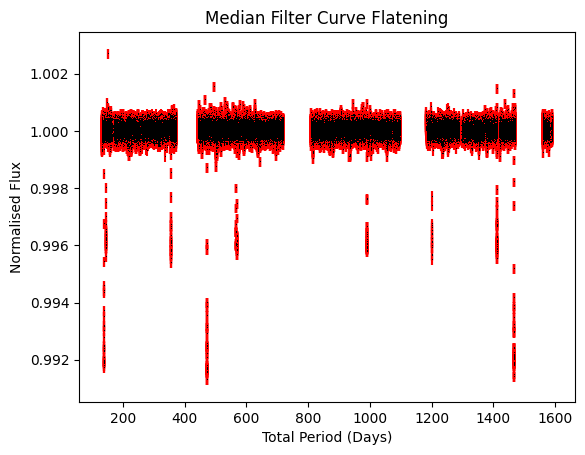

In [326]:
# Continuing with Median Filter Method
full_time, full_flux, full_fluxerror = [],[],[]

for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    
    # Removing infinites/zeros
    tmpmask = np.isfinite(tmpflux)
    
    # Applying Median filter
    med_filt = medfilt((tmpflux[tmpmask]).astype(np.float64), kernel_size=111)
    filttime = tmptime[tmpmask]
    filtflux = tmpflux[tmpmask] / med_filt
    filterror = tmperror[tmpmask] / med_filt
    
    # Removing values 3 standard deviations above 1
    std_dev = np.nanstd(filtflux)
    ymask = (filtflux < (1 + 3*std_dev))
    
    time = filttime[ymask]
    flux = filtflux[ymask]
    fluxerror = filterror[ymask]

    # Appending full data to empty lists
    full_time.extend(time)
    full_flux.extend(flux)
    full_fluxerror.extend(fluxerror)
    
    # Plotting full data with errors
    plt.errorbar(full_time, full_flux, full_fluxerror, ls='None', c='red')
    plt.plot(full_time, full_flux, ls='None', marker=',', c='black', label='Data')
    plt.title('Median Filter Curve Flatening')
    plt.ylabel('Normalised Flux')
    plt.xlabel('Total Period (Days)')

**Fig. 4.** *Plot showing the full normalised kepler lightcurve using the Median Filter method, with the period in days plotted against the total flux in normalised units and erros shown in red*.

With this normalized, flattened and noise reduced lightcurve, we can identify the periodicities of exoplanet transits. Immediately, we notice these huge dips from the main portion of the curve at 1.000, we can safely identify these are associated to large planets transiting the star.

$\textit{N.B. The function below is defined here as it primarily used later on in section 2.3, but used as a periodicity check in section 2.2.}$

In [19]:
# Defining Light Curve Folding function
def fold_lightcurve(time, flux, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    flux: input flux
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded flux, folded error
    """
    
    # Imports light curve data into a pandas dataframe
    data = pd.DataFrame({'time': time, 'flux': flux, 'error': error})
    
    #  Curve is folded on the period point provided   
    data['phase'] = data.apply(lambda x: ((x.time/ period) - np.floor(x.time / period)), axis=1)
    
    # Folded curve is mirrored on the point of folding to provide a full curve in time
    phase_long = np.concatenate((data['phase'], data['phase'] + 1.0, data['phase'] + 2.0))
    flux_long = np.concatenate((flux, flux, flux))
    err_long = np.concatenate((error, error, error))
    
    return(phase_long, flux_long, err_long)

$\textbf{2.2 Periodicities and Lomb-Scargle Periodogram}$

With the flattened lightcurve, we know that the exoplanets in the system will periodically transit the star with similar dips in flux. Since these periodicities are similar in intensity for each planet, we can use a Fourier-like transform to group the intensities for each period. 

We use the Lomb-Scargle method to iterate the full light curve over frequency space and then back to phase phase synonymous to a Fourier Transform. The Lomb-Scargle periodogram is a well-known algorithm for detecting and characterizing periodicity in unevenly-sampled time-series data. We will not describe the exact process in which the Lomb-Scargle function identifies periodicities, though indicate that it is motivated by Fourier Analysis, Least Squares Method, and can be derived from the principles of Bayesian probability theory.$^{[6]}$

The first iteration of Lomb-Scargle finds the intensity distribution of frequencies present in the light curve.

Text(0.5, 0, 'Frequency (1/days)')

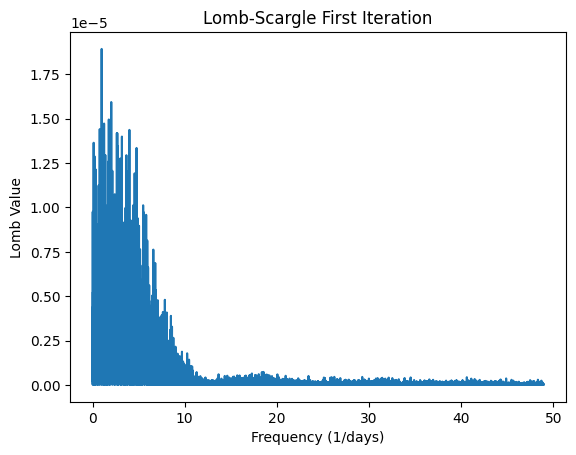

In [20]:
# Lombscargle First Iteration over frequency space

# Find minimum time and maximum time
# Assume minimum time is equivalent to time between two adjacent values
min_time = full_time[1] - full_time[0]

# Maximum time is difference between max vs min time
max_time = np.max(full_time) - np.min(full_time)

# Convert times to frequencies
max_freq = 1 / min_time
min_freq = 1 / max_time

# Make frequency axis with spacing of 50000
freqs = np.linspace(min_freq,max_freq, 50000)

# Apply lombscargle over frequency space
lomb = scipy.signal.lombscargle(full_time, full_flux, freqs, precenter=True)
plt.plot(freqs, lomb)
plt.title('Lomb-Scargle First Iteration')
plt.ylabel('Lomb Value')
plt.xlabel('Frequency (1/days)')

**Fig. 5.** *Plot showing the first iteration of Lomb-Scargle over frequency space with the Frequency plotted against the Lomb intensity value*.

The second iteration of Lomb-Scargle now returns the intensity distribution of identified periods, also known as the periodogram. This shows the intensity of the most prevalent periods, i.e. the period of the most prominent flux dips.

Text(0.5, 0, 'Period (days)')

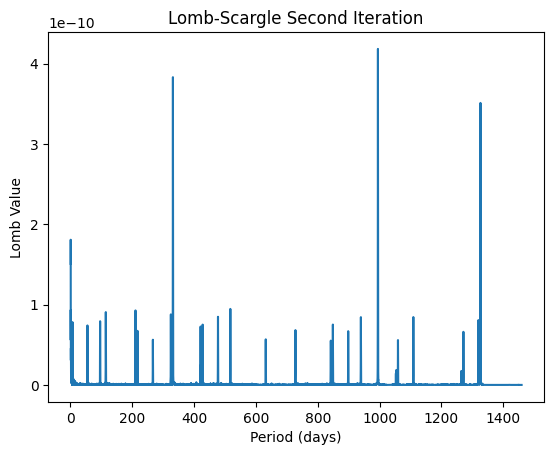

In [21]:
# Lomb-Scargle Second Iteration over time space

# Period axis made with minimum and maximum time of lightcurve
period = np.linspace(1, max_time, 50000)

# Second iteration of lomb-scargle returning to phase space
lomb2 = scipy.signal.lombscargle(freqs, lomb, period, precenter=True)
plt.plot(period, lomb2)
plt.title('Lomb-Scargle Second Iteration')
plt.ylabel('Lomb Value')
plt.xlabel('Period (days)')

**Fig. 6.** *Plot showing the second iteration of Lomb-Scargle over phase space with the period plotted against the Lomb intensity value*.

Now we need to identify the prominent period peaks that are due to an exoplanet orbit rather than factors such as periodic noise. We do this by first finding the associated period values for lomb values above a certain value - this isolates all of the period locations of substantial lomb. The limitation of this is with smaller planet transits that may be classified as noise below this value.

We then interpolate the localized period values to find the exact transit dips which folds the light curve symmetrically - this will be explained in section 2.3. Determining this by eye, we can identify the best fit to suitable accuracy. Thus, identifying the periodicities to an accuracy of the interpolation range.

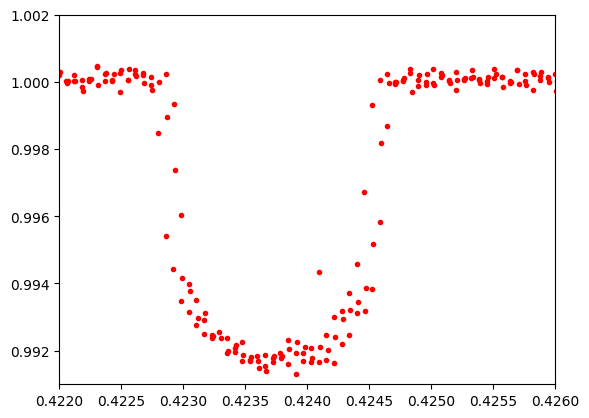

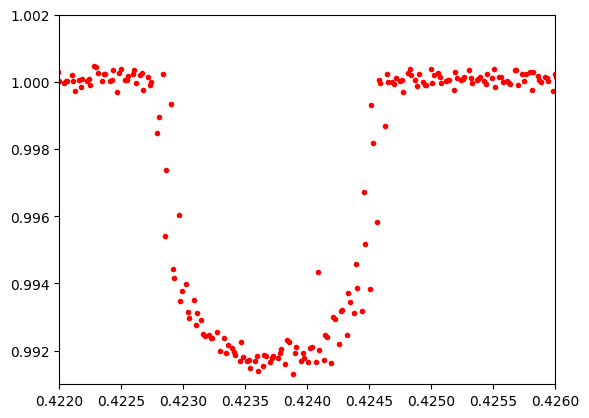

In [22]:
# Identifying Lomb values above a certain value to find periods
flux_lim = np.argwhere(lomb2 > 0.5e-10)
periods = period[flux_lim]

# For loop used to iterate over various period values until correct light curve fold is found

# Example with P1=331.6

# Interpolation range
period_find = 331.590
# Accuracy of 0.01/20
delta_P = 0.01
period_list = []
for i in range(2): #20
    points = delta_P/2 #20
    period_find = period_find + points
    period_list.append(period_find)
period_list

# Plots folded light curve for the entire list of iterated periods
for i in range(len(period_list)):
    ini_phase, ini_phase_flux, ini_phase_error = fold_lightcurve(full_time, full_flux, full_fluxerror, period_list[i])
    fig, (axes) = plt.subplots()
    plt.plot(ini_phase, ini_phase_flux, ls='None', marker='.', c='red', label='Data')
    
    # Focus on identified transit location found in section 2.3
    plt.xlim(0.422,0.426)
    plt.ylim(0.991,1.002)

**Fig. 7.** *Plots showing 20 iterated period values on identified transits with the folded lightcurve*.

Using this method of selection and interpolation, we identify 4 periods, though many more are likely to be in the periodogram. This inefficiency of finding the periods is a limitation to this method.

Below, the found periods are plotted recurring against the main periodogram, this visually verifies that these periods are repeating.

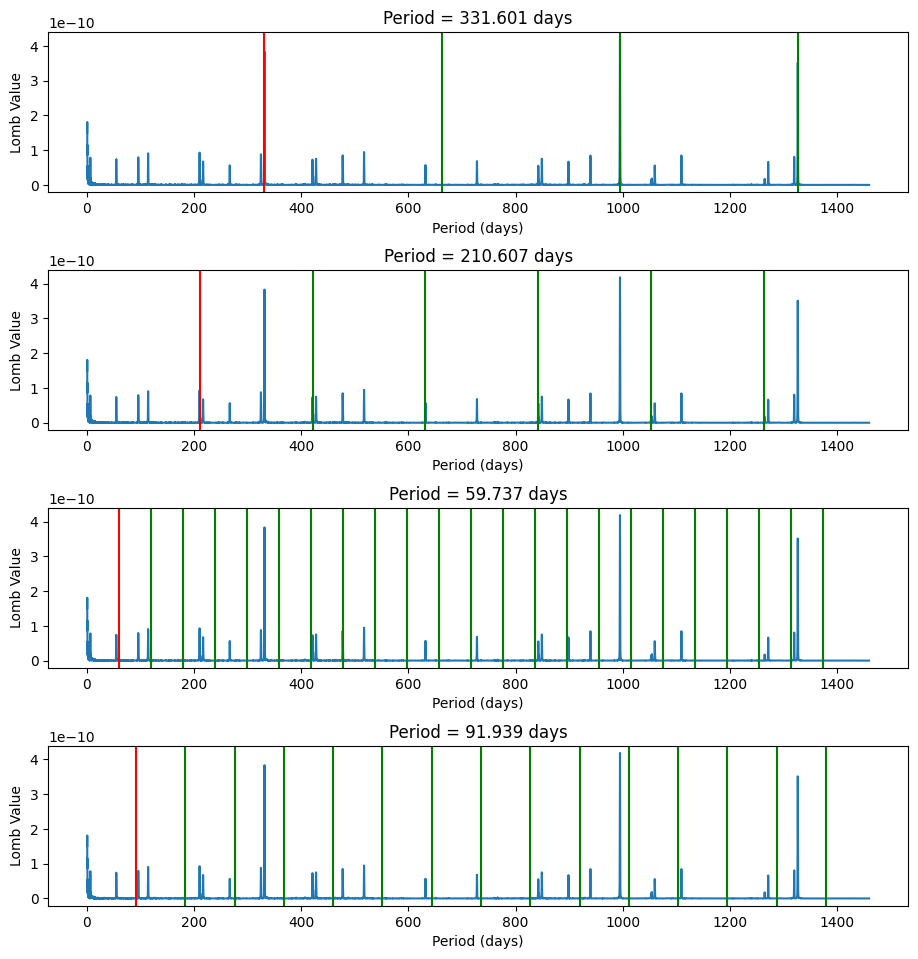

In [25]:
# Found periods
P1 = 331.601
P2 = 210.607
P3 = 59.737
P4 = 91.939
periods = [P1, P2, P3, P4]
multipliers = [
    list(range(2, 5)),
    list(range(2, 7)),
    list(range(2, 24)),
    list(range(2, 16))
]

fig, axes = plt.subplots(4, figsize=(10, 10))
fig.tight_layout(pad=3.5)

# Lomb2 period plots
for i, (ax, P, multiples) in enumerate(zip(axes, periods, multipliers)):
    ax.plot(period, lomb2)
    ax.set_ylabel('Lomb Value')
    ax.set_xlabel('Period (days)')
    ax.set_title(f'Period = {P} days')
    
    # Actual period indicated in Red
    ax.axvline(P, c='r')
    
    # Repeated period checks indicated in Green
    for m in multiples:
        ax.axvline(P * m, c='green')

**Fig. 8.** *Plots showing the 4 identified periods repeated on the periodogram*.

$\textbf{2.3 Folding the lightcurve}$

Now that the periods have been identified, we want to fold the main lightcurve about this period location. With long light curves, we fold the curve - shifting the period so we can see a more detailed view of am individual transit. This returns the time axis in a reduced phase space for that specified period. We see that exact planet periods fold the curve correctly - defined as the curve folding symmetrically at each transit location. i.e. the dip is continuous and does not overlap at the top.

We fold the full lightcurve about each 4 periods and plot them to identify suitable transit dips.

In [34]:
# Full lightcurve folded with chosen period
ini_phases = []
for P in periods:
    ini_phase, ini_flux, ini_error = fold_lightcurve(full_time, full_flux, full_fluxerror, P)
    ini_phases.append((ini_phase, ini_flux, ini_error))

On the left column, we have the plots of the folded light curves and on the right the identified transit. These transit locations will be used later on.

We see that for the Period of 210.6 days, the folded transit location is not entirely symmetric - this is the case with every transit in the folded light curve. This will be discussed further in Section 3.2.

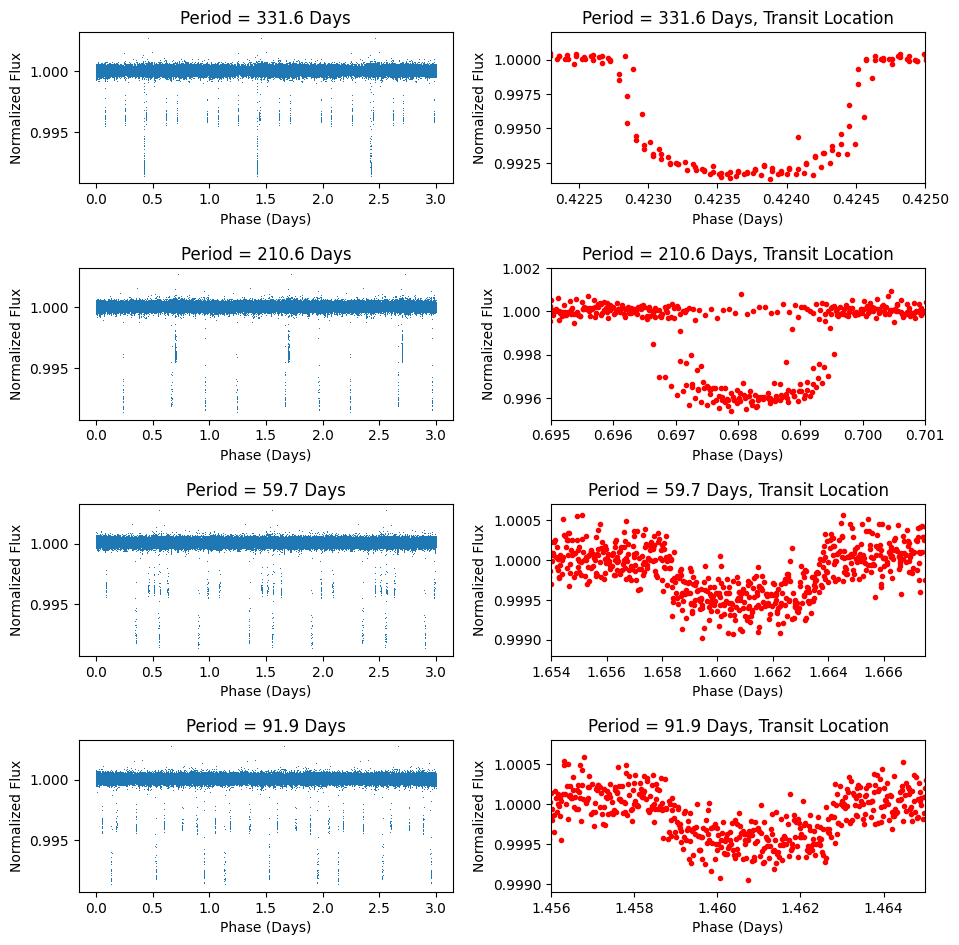

In [51]:
# Identifying suitable transit locations and plotting folded lightcurves in transit locations
titles = ['331.6 Days', '210.6 Days', '59.7 Days', '91.9 Days']
xlims = [(0.4223, 0.425), (0.695, 0.701), (1.654, 1.6675), (1.456, 1.465)]
ylims = [(0.991, 1.002), (0.995, 1.002), (0.9988, 1.0007), (0.9989, 1.0008)]

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)

for i, (P, (phase, flux, error), title, xlim, ylim) in enumerate(zip(periods, ini_phases, titles, xlims, ylims)):
    # Full plot
    axes[i, 0].plot(phase, flux, ls='None', marker=',', label='Data')
    axes[i, 0].set_title(f'Period = {title}')
    axes[i, 0].set_ylabel('Normalized Flux')
    axes[i, 0].set_xlabel('Phase (Days)')
    
    # Zoomed transit plot
    axes[i, 1].plot(phase, flux, ls='None', marker='.', c='red', label='Data')
    axes[i, 1].set_xlim(xlim)
    axes[i, 1].set_ylim(ylim)
    axes[i, 1].set_title(f'Period = {title}, Transit Location')
    axes[i, 1].set_ylabel('Normalized Flux')
    axes[i, 1].set_xlabel('Phase (Days)')

**Fig. 9.** *Plots showing the 4 folded light curve phase graphs about their associated periods on the left column and identified transit locations on the right*.

Defining the transit location ranges to stored variables.

In [40]:
# Identifying transit zones and assigning x/y limits
x_lower1 = 0.4223
x_upper1 = 0.425
y_lower1 = 0.991
y_upper1 = 1.002

x_lower2 = 0.695
x_upper2 = 0.701
y_lower2 = 0.995
y_upper2 = 1.002

x_lower3 = 1.654
x_upper3 = 1.6675
y_lower3 = 0.9988
y_upper3 = 1.0007

x_lower4 = 1.456
x_upper4 = 1.465
y_lower4 = 0.99890
y_upper4 = 1.0008

The 4 transit zones are plotted with their associated flux error graphs, an indication of the increased noise for the relatively smaller transit dips.

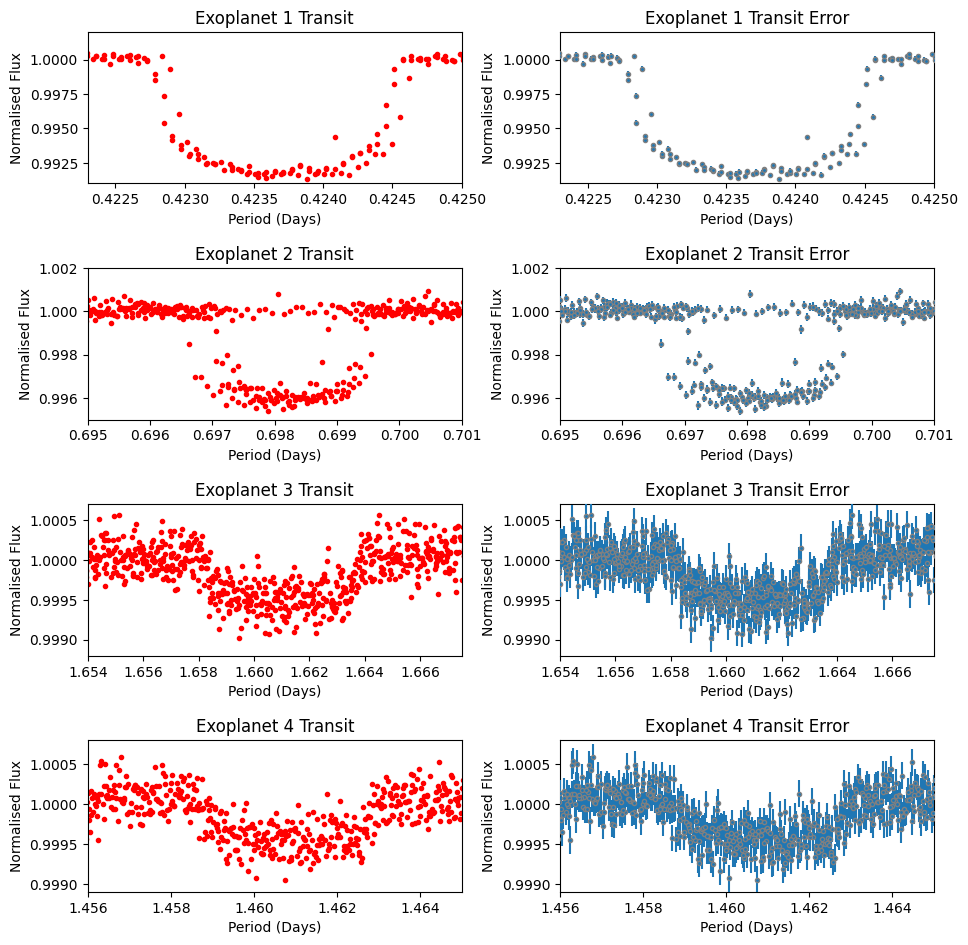

In [39]:
# Plotting folded lightcurves with identified transit zones with associated errors
titles = ['Exoplanet 1 Transit', 'Exoplanet 2 Transit', 'Exoplanet 3 Transit', 'Exoplanet 4 Transit']
error_titles = ['Exoplanet 1 Transit Error', 'Exoplanet 2 Transit Error', 'Exoplanet 3 Transit Error', 'Exoplanet 4 Transit Error']

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)

for i, ((phase, flux, error), title, error_title, xlim, ylim) in enumerate(zip(ini_phases, titles, error_titles, xlims, ylims)):
    axes[i, 0].plot(phase, flux, ls='None', marker='.', c='red', label='Data')
    axes[i, 0].set_xlim(xlim)
    axes[i, 0].set_ylim(ylim)
    axes[i, 0].set_title(title)
    axes[i, 0].set_ylabel('Normalised Flux')
    axes[i, 0].set_xlabel('Period (Days)')
    
    axes[i, 1].errorbar(phase, flux, yerr=error, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey')
    axes[i, 1].set_xlim(xlim)
    axes[i, 1].set_ylim(ylim)
    axes[i, 1].set_title(error_title)
    axes[i, 1].set_ylabel('Normalised Flux')
    axes[i, 1].set_xlabel('Period (Days)')

**Fig. 10.** *Plots showing the 4 identified transit locations on the folded light curves and the associated error plots on the right indicating the increased error for smaller transit dips*.

$\textbf{2.4 Model Fitting \& Transit Depths}$

$\textbf{2.4.1 Fitting Models}$

With the identified transits, we want to measure the transit depth so that we can calculate characteristics of the exoplanets. We require a model that can be optimised on a free parameter and initial values to accurately shape the transits. 

These functions must have one free parameter that controls the shape of the transit and the remainder of the parameters being used as boundary conditions to identify the transit location. The function should also have a parameter that identifies the transit depth as this is our primary objective.

Two functions have been used, firstly a Quartic model and secondly an Inverted Bell Curve function.

The Quartic model is characteristically the exact shape of a typical transit. This works well when the baseline to ingress/egress slope is steep (a sharp drop). Whereas the Inverted Bell Curve models transits that have shallow drops far better. We will see this later on in section 2.4.2.

In [41]:
# Function 1 to curvefit - Quartic

def quartic_transit(t, a, T, d, b):
    """
    A function to describe the shape of a transit, including the in- and egress using a quartic
    t: time (or phase)
    a: free parameter that controls the shape of the transit, typically ~>50
    T: location of the mi-transit point (either in time or phase)
    d: depth of the transit (e.g. -0.1 for a 10% drop in flux)
    b: value of lightcurve outside transit (typically 1)
    returns: f(t) for the transit
    """
    return (a*(t-T)**4 + 0.5*d) - abs((a*(t-T)**4 + 0.5*d)) + b

Quartic Function (QT):

$ {f(t)} = { a(t - T)^{4} + 0.5d } - |{a(t-T)^{4}} + 0.5d| + b$

In [42]:
# Function 2 to curvefit - Inverted bell curve

def IBC(t, alpha, beta, gamma, b):
    """
    A function to describe the shape of a transit, including the in- and egress using an inverted bell-curve
    t: time (or phase)
    alpha: depth of bell curve - free parameter
    beta: location of mid point of bell curve
    gamma: width of bell curve - free parameter
    b: value of lightcurve outside transit (typically 1)
    returns: f(t) for the transit
    """
    return (-alpha*np.exp((- ((t - beta)**2) / gamma)) + b)

Inverted Bell Curve (IBC):

$ f(t) = -\alpha e^{\dfrac{-(t-\beta)^{2}}{\gamma}} + b $

$\textbf{2.4.2 Transit Boundaries}$

Before we can optimize the models to the transit, we need to isolate the full phase curves on the chosen transit locations. 

We utilize the transit location variables stored in the previous section and mask individual folded lightcurve with these boundaries. The masked regions must be resorted to have correctly corresponding flux to phase values.

In [43]:
# Zooming in on transit zones and sorting the data for each planet
xlims = [(x_lower1, x_upper1), (x_lower2, x_upper2), (x_lower3, x_upper3), (x_lower4, x_upper4)]
sorted_phases, sorted_fluxes, sorted_errors = [], [], []

for i, (p, f, e) in enumerate(ini_phases):
    # Zoom in on transit zones
    phase_lims = (p > xlims[i][0]) & (p < xlims[i][1])
    
    # Apply mask to phase, flux, and error
    phase_new, flux_new, error_new = p[phase_lims], f[phase_lims], e[phase_lims]
    
    # Sort data
    index_sort = np.argsort(phase_new)
    sorted_phases.append(phase_new[index_sort])
    sorted_fluxes.append(flux_new[index_sort])
    sorted_errors.append(error_new[index_sort])

$\textbf{2.4.2 Curve Fitting}$

The models are now optimize to fit the transit locations using the curve fit function. This function takes the input parameters on the transit phase curve and optimizes the model to fit as accurately as possible.

The inputs for the initial values are corresponding to the definition of each variable for the associated model. Therefore, we provide the curve fit function with some preliminary values that need not be entirely accurate and it will find the best fit solution with an associated error for each value - these are stored in "opt" and "cov" respectively. 

In [45]:
# Model fitting for planets
IBC_vals = [
    [0.0085, 0.4237, 0.0000001, 1.000],  # Planet 1
    [0.004, 0.6982, 0.0000001, 1.000],   # Planet 2
    [0.0007, 1.661, 0.000001, 1.000],    # Planet 3
    [0.0004, 1.461, 0.000001, 1.000]     # Planet 4
]

QT_vals = [
    [6e9, 0.4237, -0.0085, 1.000],  # Planet 1
    [6e8, 0.6982, -0.004, 1.000],   # Planet 2
    [4e6, 1.661, -0.0007, 1.000],   # Planet 3
    [4e6, 1.461, -0.0004, 1.000]    # Planet 4
]

# Lists to store the results
IBC_opts, IBC_covs, QT_opts, QT_covs = [], [], [], []

# Loop through each planet's data
for i in range(4):
    # Fit IBC model
    IBC_opt, IBC_cov = curve_fit(IBC, sorted_phases[i], sorted_fluxes[i], p0=IBC_vals[i], sigma=sorted_errors[i])
    IBC_opts.append(IBC_opt)
    IBC_covs.append(IBC_cov)
    
    # Fit Quartic Transit model
    QT_opt, QT_cov = curve_fit(quartic_transit, sorted_phases[i], sorted_fluxes[i], p0=QT_vals[i], sigma=sorted_errors[i])
    QT_opts.append(QT_opt)
    QT_covs.append(QT_cov)

The initial value and optimized models are plotted above the transit phase curve, demonstrating the accuracy of the curve fitting.

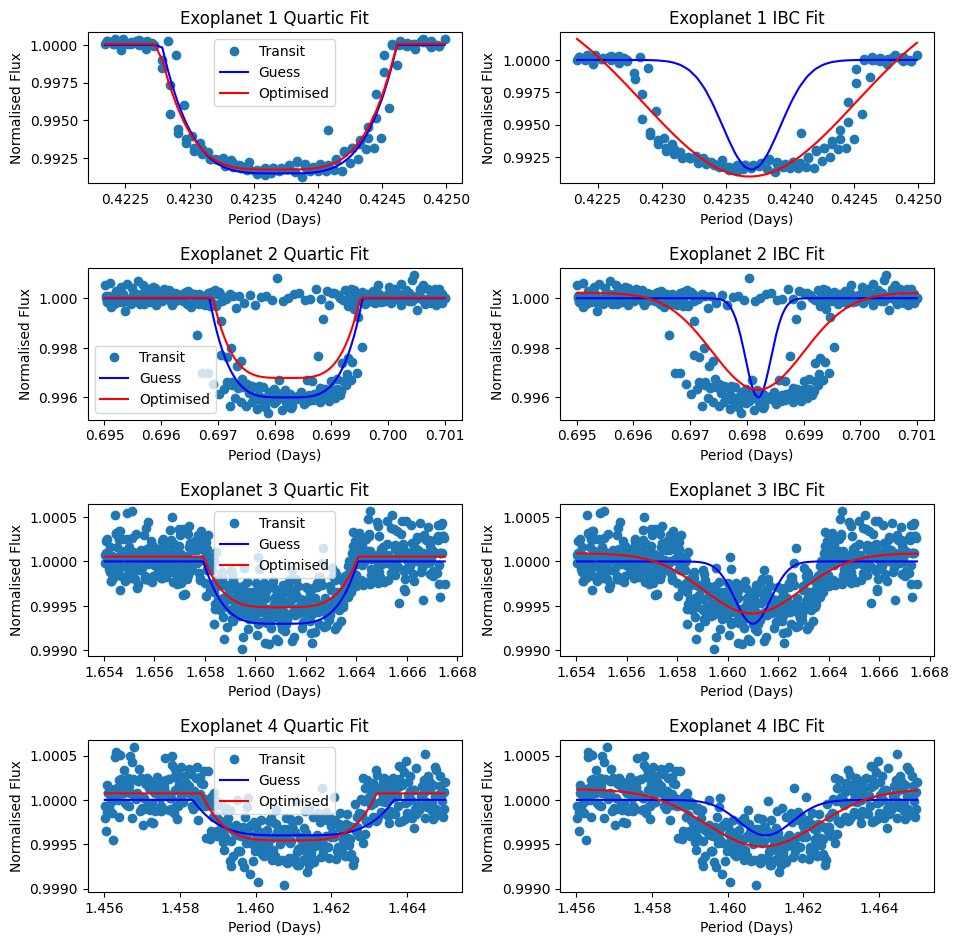

In [50]:
# Plotting QT & IBC models with inital and optimised values
titles = ['Exoplanet 1', 'Exoplanet 2', 'Exoplanet 3', 'Exoplanet 4']

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)

# Loop through each planet to plot both models
for i in range(4):
    # Quartic Transit (QT) Fit
    axes[i, 0].plot(sorted_phases[i], sorted_fluxes[i], ls='None', marker='o', label='Transit')
    axes[i, 0].plot(sorted_phases[i], quartic_transit(sorted_phases[i], *QT_vals[i]), c='blue', label='Guess')
    axes[i, 0].plot(sorted_phases[i], quartic_transit(sorted_phases[i], *QT_opts[i]), c='red', label='Optimised')
    axes[i, 0].set_title(f'{titles[i]} Quartic Fit')
    axes[i, 0].legend(loc="best")
    axes[i, 0].set_ylabel('Normalised Flux')
    axes[i, 0].set_xlabel('Period (Days)')
    
    # Inverted Bell Curve (IBC) Fit
    axes[i, 1].plot(sorted_phases[i], sorted_fluxes[i], ls='None', marker='o', label='Transit')
    axes[i, 1].plot(sorted_phases[i], IBC(sorted_phases[i], *IBC_vals[i]), c='blue', label='Guess')
    axes[i, 1].plot(sorted_phases[i], IBC(sorted_phases[i], *IBC_opts[i]), c='red', label='Optimised')
    axes[i, 1].set_title(f'{titles[i]} IBC Fit')
    axes[i, 1].set_ylabel('Normalised Flux')
    axes[i, 1].set_xlabel('Period (Days)')

# Show the plot
plt.show()

**Fig. 11.** *Plots showing the 4 identified transits with the initial value model overlayed in blue and the optimized model overlayed in red. The left column shows the Quartic model and right column shows the Inverted Bell Curve model*.

$\textbf{2.4.3 Accuracy of Model Fitting}$

With the optimized values for the models to fit the transits, we need to determine the accuracy of this model compared to the expected values at each point. To do this, a Chi-Squared test is executed, which let's us figure out if the data is as expected. Providing the base data, the modeled curve, and the expected data, the transit location curve.

$$ \chi^{2} = \sum \dfrac{(O_{i}-E_{i})^{2}}{E_{i}}$$

Where, $\chi^{2}$ is chi-squared, $O_{i}$ is the observed value and $E_{i}$ is the expected value.

The reduced chi-squared value is then an indication in goodness of fit.

Such that, the reduced chi-squared is equal to the chi-squared value divided by the number of data points. Where the data points is equal to the number of phase values (length of phase window) less the degrees of freedom in the model (3), less the number of free parameters (1). The closer this value is to 1, the better the fit.

In [52]:
# Curve fitting analysis function

def chisquared(y, error, ymodel):
    """
    A function to describe the chi squared analytic
    y: transit location flux
    error: transit location flux error
    ymodel: model fitted to transit location with optimized values
    returns: chi-squared value for accuracy of model fitting
    """
    return np.sum((y-ymodel)**2/error**2)

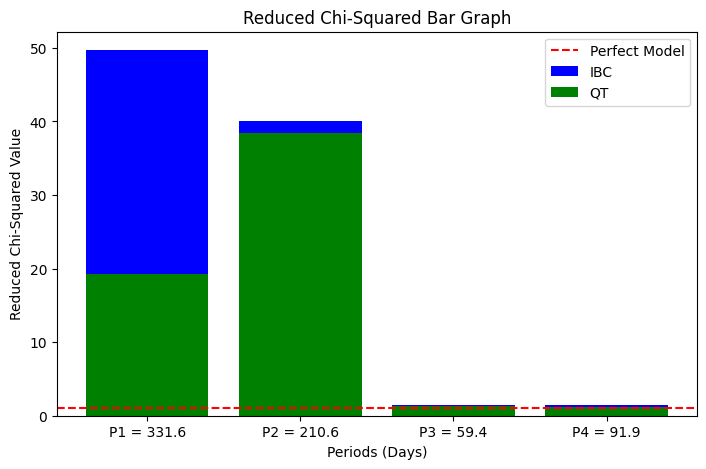

Exo1 QT Reduced Chi-Squared = 19.29
Exo1 IBC Reduced Chi-Squared = 49.72

Exo2 QT Reduced Chi-Squared = 38.41
Exo2 IBC Reduced Chi-Squared = 40.13

Exo3 QT Reduced Chi-Squared = 1.30
Exo3 IBC Reduced Chi-Squared = 1.48

Exo4 QT Reduced Chi-Squared = 1.25
Exo4 IBC Reduced Chi-Squared = 1.39



In [122]:
# Lists to store the reduced chi-squared values
IBC_reduced_chis = []
QT_reduced_chis = []

# Loop through each planet's data
for i in range(4):
    # Chi-squared and reduced chi-squared for Quartic Transit (QT)
    QT_chi = chisquared(sorted_fluxes[i], sorted_errors[i], quartic_transit(sorted_phases[i], *QT_opts[i]))
    QT_len = len(sorted_phases[i]) - 3 - 1
    QT_reduced_chi = QT_chi / QT_len
    QT_reduced_chis.append(QT_reduced_chi)
    
    # Chi-squared and reduced chi-squared for Inverted Bell Curve (IBC)
    IBC_chi = chisquared(sorted_fluxes[i], sorted_errors[i], IBC(sorted_phases[i], *IBC_opts[i]))
    IBC_len = len(sorted_phases[i]) - 3 - 1
    IBC_reduced_chi = IBC_chi / IBC_len
    IBC_reduced_chis.append(IBC_reduced_chi)

# Period labels for the bar plot
Period_list = ['P1 = 331.6', 'P2 = 210.6', 'P3 = 59.4', 'P4 = 91.9']

# Plot the Reduced Chi-Squared values as a bar graph
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 0.8])
width = 0.45

# Plot IBC and QT chi-squared values side by side
ax.bar(Period_list, IBC_reduced_chis, color='b', label='IBC')
ax.bar(Period_list, QT_reduced_chis, color='g', label='QT')

# Add a horizontal line for perfect fit (chi-squared = 1)
ax.axhline(1, color='r', linestyle='--', label='Perfect Model')

ax.set_title('Reduced Chi-Squared Bar Graph')
ax.set_xlabel('Periods (Days)')
ax.set_ylabel('Reduced Chi-Squared Value')
ax.set_xticks(np.arange(len(Period_list)))
ax.set_xticklabels(Period_list)
ax.legend()
plt.show()

# Print reduced chi-squared values for each planet
for i in range(4):
    print(f'Exo{i+1} QT Reduced Chi-Squared = {QT_reduced_chis[i]:.2f}')
    print(f'Exo{i+1} IBC Reduced Chi-Squared = {IBC_reduced_chis[i]:.2f}\n')

**Fig. 12.** *Bar graph plots showing the Reduced Chi-Squared value for both IBC and QT models fitted to the transit location. An indicator of "goodness of fit", with the value closer to 1 being ideal*.

We see that the model fit best for the transit with period 91.9 days, with the smallest reduced-chi squared values. In all transits, the quartic model outperformed the inverted bell curve model, though not by much in the 91.9 period transit. This will be investigated in depth in the discussion, see Section 3.1.

$\textbf{2.5 Transit Depth Measured Values}$

Having assessed that the quartic model is a better fit to the transits, we extract the transit depths from the optimized values.

Below, the transit depths are listed for each exoplanet.

In [63]:
# Extract the transit depth (QT_opt[*][2]) and base (QT_opt[*][3]) for each planet
QT_opt1, QT_opt2, QT_opt3, QT_opt4 = QT_opts
transit_depths = [QT_opt1[2], QT_opt2[2], QT_opt3[2], QT_opt4[2]]
bases = [QT_opt1[3], QT_opt2[3], QT_opt3[3], QT_opt4[3]]

# Loop through each planet and print the desired values
for i in range(4):
    print(f'Planet{i+1}: [Period, T-Depth, Base] = ({periods[i]:.1f}, {transit_depths[i]:.7f}, {bases[i]:.7f})')

Planet1: [Period, T-Depth, Base] = (331.6, -0.0083001, 1.0000576)
Planet2: [Period, T-Depth, Base] = (210.6, -0.0032332, 1.0000183)
Planet3: [Period, T-Depth, Base] = (59.7, -0.0005690, 1.0000540)
Planet4: [Period, T-Depth, Base] = (91.9, -0.0005313, 1.0000738)


$\textbf{2.6 Exoplanet Characteristics}$

Below, we use the transit depths to determine the planetary radii and semi-major axis in standard, astro (Jupiter) and astro (Earth) units.

Using Kepler's Laws we find the radius of the planet by

$ \dfrac{\Delta{F}}{F} = \dfrac{{R_{Planet}}^2}{{R_{Star}}^2} \Rightarrow R_{Planet} = R_{Star}\sqrt{\dfrac{\Delta{F}}{F}} $

and the semi-major axis: $P^2 = \dfrac{4\pi{}^2}{GM}a^3 \Rightarrow a = {\left(G{M_{Star}}\dfrac{P^2}{4\pi^{2}}\right)}^{1/3} $

With $G = 6.6743\times10^{-11}$, $M_{Star}$ and $R_{Star}$ previously defined.

Hence, the period is our found periods $P_{n}$, the transit depth is our $\Delta{F_{n}}$ and the baseline is our $F_{n}$

In [206]:
# Exoplanet Characteristics

# Provided masses in Jupiter units
M_Jup = [1.2, 0.8, 'N/A', 'N/A']

# Provided masses in SI units
M_SI = [mass * M_J if mass != 'N/A' else 'N/A' for mass in M_Jup]

# Provided masses in Earth units
M_Ear = [mass / M_E if mass != 'N/A' else 'N/A' for mass in M_SI]

# Relative transit depth value (positive rather than negative dip)
deltaF = [-opt[2] for opt in [QT_opt1, QT_opt2, QT_opt3, QT_opt4]]

# Baseline value
F = [opt[3] for opt in [QT_opt1, QT_opt2, QT_opt3, QT_opt4]]

# Planetary radii in SI units
R = [R_s * (delta / F)**0.5 for delta, F in zip(deltaF, F)]

# days to seconds conversion
s = 24*60*60

# Semi-major axis in SI units
a = [(G * M_s * (P * s)**2 / (4 * np.pi**2))**(1/3) for P in [P1, P2, P3, P4]]

# Conversion of radii and semi-major axis    
R_Jup = [r / R_J for r in R]
R_Ear = [r / R_E for r in R]
SMA = [a_val / AU for a_val in a]

$ \textbf{2.7 Error Analysis} $

$ \textbf{2.7.1 Quadrature Analysis} $

To get the error, we use the following quadrature relations:

Additive & Subtractive error $\rightarrow$

$X = A + B$ or $X = A - B \Rightarrow \sigma_X = \sqrt{\sigma_A^2 + \sigma_B^2}$

Multiplicative & Division error $\rightarrow$

$X = k(A * B)$ or $X = k\dfrac{A}{B} \Rightarrow \dfrac{\sigma_X}{X} = \sqrt{{\left(\dfrac{\sigma_A}{A}\right)}^2 + {\left(\dfrac{\sigma_B}{B}\right)}^2}$

Exponent error $\rightarrow$

$X = A^n \Rightarrow \dfrac{\sigma_X}{X} = n\dfrac{\sigma_A}{A}$


For all of these errors, they are displayed as $X (±)\sigma_{X}$

$ \textbf{2.7.2 Errors Required} $

1. Error in Period measurement - $\sigma_{P}$:

The periods obtained can be replotted on the full flattened lightcurve - the locations of repeated periodicities are compared to these replotted points. From this we can get an average variance from actual vs observed periodicity. This is seen in detail in the next Section - 2.7.3.

2. Error in Transit Depth & Baseline measurement - $\sigma_{\Delta{F}}$ and $\sigma_{F}$:

The curve fit function used to optimise the models to the transits also provide a covariance matrix - giving errors associated with the optimised values. The matrix is a 4x4 array, with the Transit Depth metadata & Baseline associated to the third & fourth column (array values 2 & 3). 

The errors in this matrix are the square root of the leading diagonal, so we can extract this using the np.sqrt(np.diag()) functions on the array values 2 & 3.

The value of this error will not be stated as it is only needed for the calculation of the error in our Radius.

3. Error in Radius calculation - $\sigma_{R_{p}}$:

$ R_{Planet} = R_{Star}\sqrt{\dfrac{\Delta{F}}{F}} $

This can be split into $ R_{p} = R_{s} * Y$ where $ Y = X^{1/2}$ and $X = \dfrac{\Delta{F}}{F}$

The error in $ X = \dfrac{\Delta{F}}{F} \Rightarrow \dfrac{\sigma_{X}}{X} = \sqrt{\left(\dfrac{\sigma_{\Delta{F}}}{\Delta{F}}\right)^2 + {\left(\dfrac{\sigma_F}{F}\right)}^2 } $

The error in $ Y = \left(\dfrac{\Delta{F}}{F}\right)^{1/2} \Rightarrow \dfrac{\sigma_{Y}}{Y} = \dfrac{1}{2}\dfrac{\sigma_{X}}{X} $

The error in $ R_{p} = R_{s} * Y \Rightarrow \dfrac{\sigma_{R_{p}}}{R_{p}} = \sqrt{{\left(\dfrac{\sigma_{R_{s}}}{R_{s}}\right)}^2 + {\left(\dfrac{\sigma_Y}{Y}\right)}^2}$

Plugging in $\dfrac{\sigma_{Y}}{Y}$ into $\sigma_{R_{p}} \rightarrow $ 

Giving the total error in $R_{p} \Rightarrow \sigma_{R_{p}} = {R_{p}}\sqrt{{\left(\dfrac{\sigma_{R_{s}}}{R_{s}}\right)}^2 + \dfrac{1}{4}{\left[{\left(\dfrac{\sigma_{\Delta{F}}}{\Delta{F}}\right)}^2 + {\left(\dfrac{\sigma_F}{F}\right)}^2\right]}}$

4. Error in SMA calculation - $\sigma_{a}$:

$ a \approx {\left(G{M_{Star}}\dfrac{P^2}{4\pi^{2}}\right)}^{1/3} $

This can be simplified as $ a = {\left(\dfrac{G}{4\pi^{2}}\right)}^{1/3}{\left(M_{s}^{1/3}P^{2/3}\right)} $ 

Hence, the associated error is $ \dfrac{\sigma_{a}}{a} = \dfrac{\sigma_{M_{s}}}{M_{s}}*\dfrac{\sigma_{P}}{\sigma_{P}} $

So, $ M_{s} \Rightarrow \dfrac{1}{3}\dfrac{\sigma_{M_{s}}}{M_{s}} $ and $ P \Rightarrow \dfrac{2}{3}\dfrac{\sigma_{P}}{P} $

Giving the total error in $a \Rightarrow \sigma_{a} = a \sqrt{ {\left(\dfrac{1}{3}\dfrac{\sigma_{M_{s}}}{M_{s}}\right)}^2 + {\left(\dfrac{2}{3}\dfrac{\sigma_{P}}{P}\right)}^2 } $

$ \textbf{2.7.3 Residuals \& Linear Regression} $

To find the error in the identified period, we find the locations of repeated periods. Thus, finding the residual difference between the exact location of transits and the expected location from repeated periods. This will allow us to produce a linear regression plot and identify the general error in period.

In [70]:
def lin_reg(time, flux, phase, period, depth):
    """
    time: full time array from main lightcurve
    flux: full flux array from main lightcurve
    phase: transit phase location for first found period
    period: found period value
    depth: depth of transit at found period i.e. QT_opt[i][2]
    returns: period residual difference values and index positions
    """
    
    # find time value of transit phase position
    first_peak = period * phase
    fulltime_length = len(time)
    
    # Total iterations over full light curve
    iteration_length = int(fulltime_length / period)
    
    # Inital arrays for ouputs
    all_periods = []
    diff_list = [] 
    
    # Find positions of repeated periods
    for i in range (iteration_length):
        peaks = first_peak + (period * i)
        upper_limit = peaks + 2
        lower_limit = peaks - 2
        
        # Mask the location of found periods
        peaks_mask = (upper_limit > time) & (lower_limit < time)
        
        flux_array = np.asarray(flux)
        time_array = np.asarray(time)
        
        flux_masked = flux_array[peaks_mask]
        time_masked = time_array[peaks_mask]
        
        if len(flux_masked) == 0 or len(flux_masked) < 4:
            continue
        
        # Inital conditions for curvefit
        p0 = [1e1, peaks, depth, 1.000]
        popt, _ = curve_fit(quartic_transit, time_masked, flux_masked, p0)
        
        all_periods.append(popt[1])
        
        # Residual differences between periods
        difference = peaks - popt[1]
        diff_list.append(difference)
        
        # Add index to plot
        index_initial = list(range(len(diff_list)))
        index =  [x+1 for x in index_initial]
        
    return diff_list, index

In [76]:
# Executing linear regression function on transit zones
diffs, inds = [], []
for i in range(4):
    diff, ind = lin_reg(full_time, full_flux, QT_opts[i][1], periods[i], QT_opts[i][2])
    diffs.append(diff)
    inds.append(ind)

/var/folders/rw/57lr6wsn1xg3nr3drbny9mhr0000gn/T/ipykernel_98962/3305049873.py:42: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quartic_transit, time_masked, flux_masked, p0)


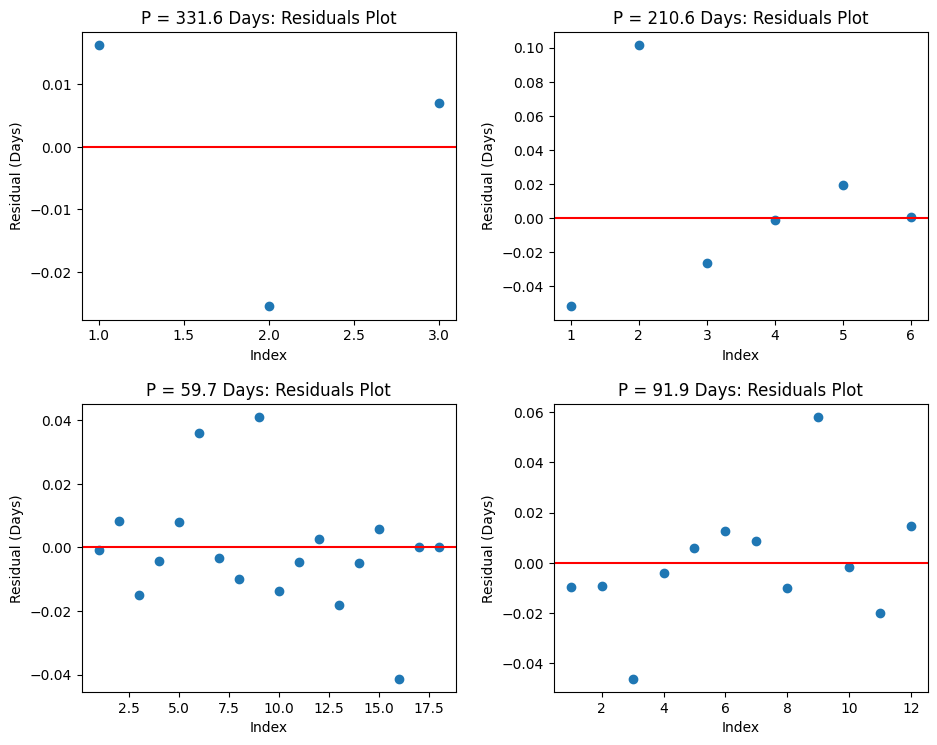

In [83]:
# Residual Plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=4.0)

# Plot residuals
for i, (diff, ind, period) in enumerate(zip(diffs, inds, np.round(periods, 1))):
    ax = axes[i // 2, i % 2]
    ax.plot(ind, diff, ls='None', marker='o')
    ax.set_title(f'P = {period} Days: Residuals Plot')
    ax.set_ylabel('Residual (Days)')
    ax.set_xlabel('Index')
    ax.axhline(0, c='r')

plt.show()

**Fig. 13.** *Plots showing the residuals for each identified Exoplanets repeated Periods*.

Using the residual plots above, we can use linear regression to find the error in the periods. 

If the true model is $$Y = \beta_{0} + \beta_{1}X + \epsilon$$
and the estimated model is $$\hat{Y} = \hat{\beta}_{0} + \hat{\beta}_{1}X $$ 

We can conduct inference on the slope of our estimated model as the slope expresses the relationship between $X$ and $Y$.

We assume that the estimated slope, $\hat{\beta}_{1}$, is a normally distributed random variable with a mean of $\beta_{1}$ and a variance equal to $\sigma^{2}$ divided by the sum of squares for $X$. i.e.:

$$ \hat{\beta}_{1} \sim N(\beta_{1}, \dfrac{\sigma^{2}}{SS_{xx}}) $$

We need to estimate $\sigma^{2}_{P}$, the variance in periodicity, so we call the estimated value.

Sample variance: 

$$ s^{2}_{\hat{\beta}_{1}} = \dfrac{\sum{(Y_{i}-\hat{Y})^{2}}}{n-2}$$

To obtain the sample standard deviation, the square root of $s^{2}$ is taken: 

$$\Rightarrow s_{\hat{\beta}_{1}} = \sqrt{\dfrac{\sum{(Y_{i}-\hat{Y})^{2}}}{n-2}}$$

Now, for the total standard error:

$$ SE_{\hat{\beta}_{1}} = \dfrac{s}{\sqrt{SS_{xx}}} = \dfrac{\sqrt{\dfrac{\sum{(Y_{i}-\hat{Y})^{2}}}{n-2}}}{\sqrt{SS_{xx}}} $$


Where $(Y_{i}-\hat{Y})$ is simply the residual difference value as $\hat{Y} = 0$. Finally, $n$ is the number of residuals found, and $SS_{xx}$ is the sum of squares for the index values.

In [95]:
# Calculates standard error
# Initialise standard error list
SE_list = []

# Iterate over the four exoplanet periods
for i in range (4):
    # Find average value of index list
    x_hat = sum(inds[i]) / len(inds[i])
    n = len(inds[i]) - 2
    SS_xx_list = []
    SS_yy_list = []
    
    # Iterate over index and residual difference list
    for j in range (len(inds[i])):
        SS_xx = (inds[i][j] - x_hat)**2
        SS_yy = (diffs[i][j])**2
    
        SS_xx_list.append(SS_xx)
        SS_yy_list.append(SS_yy)
    
    # Calculate standard error
    SE = np.sqrt(sum(SS_yy_list) / n) / np.sqrt(sum(SS_xx_list))
    SE_list.append(SE)

$ \textbf{2.7.4 Final Error Values} $

In [202]:
# Errors

# 1. Error in Period Measurement
sigmaP = SE_list
sigmaPs = np.multiply(SE_list, s)

# 2. Error in Transit Depth Measurement
sigmaF = []
sigmaDF = []
sigmaR = []
sigmaR_J = []
sigma_a = []
sigmaSMA = []
for i in range(4):
    sigmaF.append(np.sqrt(np.diag(QT_covs[i]))[3])
    sigmaDF.append(np.sqrt(np.diag(QT_covs[i]))[2])
    
    # 3. Error in Radius Calculation
    sigmaR.append(R[i]*np.sqrt((sigmaR_s/R_s)**2 + (1/4)*((sigmaDF[i]/deltaF[i])**2 + (sigmaF[i]/F[i])**2)))
    sigmaR_J.append(sigmaR[i] / R_J)
    
    # 4. Error in SMA Calculation
    sigma_a.append(a[i]*np.sqrt(((1/3)*(sigmaM_s/M_s))**2+((2/3)*(sigmaP[i]/periods[i]))**2))
    sigmaSMA.append(sigma_a[i] / AU)

$\textbf{2.8 Final Exoplanet Values}$

In [205]:
planet_names = ['21a', '21b', '21c', '21d']

# Errors in SI units
print('Standard Units')
for i in range(4):
    print(f'{planet_names[i]}: P (s), R (m), SMA (m) = [%.2e (±)%.2e],[%.2e (±)%.2e],[%.2e (±)%.2e]'%(periods[i]*s, sigmaPs[i], R[i], sigmaR[i], a[i], sigma_a[i]))

# Errors in Astro Units
print('\nAstro Units')
for i in range(4):
    print(f'{planet_names[i]}: P (days), R (R_J), SMA (AU) = [%.1f (±)%.2f],[%.2f (±)%.2e],[%.3f (±)%.3f]'%(periods[i], sigmaP[i], R_Jup[i], sigmaR_J[i], SMA[i], sigmaSMA[i]))

Standard Units
21a: P (s), R (m), SMA (m) = [2.87e+07 (±)1.89e+03],[7.68e+07 (±)3.26e+06],[1.46e+11 (±)2.17e+09]
21b: P (s), R (m), SMA (m) = [1.82e+07 (±)1.23e+03],[4.79e+07 (±)2.20e+06],[1.08e+11 (±)1.60e+09]
21c: P (s), R (m), SMA (m) = [5.16e+06 (±)7.44e+01],[2.01e+07 (±)8.88e+05],[4.65e+10 (±)6.91e+08]
21d: P (s), R (m), SMA (m) = [7.94e+06 (±)1.87e+02],[1.94e+07 (±)8.78e+05],[6.19e+10 (±)9.22e+08]

Astro Units
21a: P (days), R (R_J), SMA (AU) = [331.6 (±)0.02],[1.10 (±)4.66e-02],[0.974 (±)0.014]
21b: P (days), R (R_J), SMA (AU) = [210.6 (±)0.01],[0.69 (±)3.15e-02],[0.719 (±)0.011]
21c: P (days), R (R_J), SMA (AU) = [59.7 (±)0.00],[0.29 (±)1.27e-02],[0.311 (±)0.005]
21d: P (days), R (R_J), SMA (AU) = [91.9 (±)0.00],[0.28 (±)1.26e-02],[0.414 (±)0.006]


In [235]:
# Inserting primary data into pandas dataframe

planets_df = pd.DataFrame({
    'Planet Name': planet_names,
    'Period [Days]': periods,
    'Error (±) [Days]': sigmaP,
    'Radius [R_E]': R_Ear,
    'Radius [R_J]': R_Jup,
    'Error (±) [R_J]': sigmaR_J,
    'Mass [M_E]': M_Ear,
    'Mass [M_J]': M_Jup,
    'SMA [AU]': SMA,
    'Error (±) [AU]': sigmaSMA
}).set_index("Planet Name")

In [236]:
planets_df

,Period [Days],Error (±) [Days],Radius [R_E],Radius [R_J],Error (±) [R_J],Mass [M_E],Mass [M_J],SMA [AU],Error (±) [AU]
Planet Name,,,,,,,,,
21a,331.601,0.021923,12.048365,1.097969,0.046569,381.379772,1.2,0.973766,0.014491
21b,210.607,0.014184,7.519904,0.685290,0.031507,254.253182,0.8,0.719492,0.010707
21c,59.737,0.000861,3.154528,0.287473,0.012697,N/A,N/A,0.310603,0.004622
21d,91.939,0.002159,3.048400,0.277801,0.012553,N/A,N/A,0.414041,0.006161


**Fig. 14.** *The table above summarizes the Exoplanet metadata, in Earth units, Jupiter units and the associated errors in Jupiter units.*

$\textbf{2.9 Limitations \& Assumptions made}$

In this sub-section, we will investigate the assumptions made and limitations of of techniques implemented.

$\textbf{2.9.1 Curve Flattening Methods}$

Savitzky-Golay Method: Computation time is proportional to window width, so with a large window we would experience significant lag. The polynomial fitting also flattens peaks where the data for the peaks is defined by only a few points. This would cause issues with transits in short data measurements windows.

Median Filter: Also has issues with large window sizes with computation time of nlogn, where n is the window width. Assumes the adjacent values are sensible in producing a middle value. May struggle at regions with sporadically varying values (extreme noise).

$\textbf{2.9.2 Lomb-Scargle}$

The Lomb-Scargle method is computationally intensive, with iterations over a line spacing of 50000 taking a considerable amount of time.

$\textbf{2.9.3 Periodogram \& Periodicity identification}$

Identifying periodicities is a tedious task, having to examine multiple periodic values and then analyzing the transit locations to verify if the value produces symmetric (correctly folded) curves. Assumes the exact periods are the locations of high lomb values in the periodogram, whereas the true period may be "around" that apparent value. e.g. for P = 59.4 days, the periodogram shows the high lomb value is at around P = 55 days. Therefore, requires extrapolation for each found point to verify. As seen in Fig. 13.

$\textbf{2.9.4 Light Curve Folding}$

Requires exact period values to a relatively high level of accuracy, especially for small transits, to correctly & symmetrically fold. As seen in Fig. 14.

$\textbf{2.9.5 Model \& Curve Fitting}$

Again, a consequence of the light curve folding, if the curves are not symmetrically folded, the curve fit functions cannot correctly fit the curve as there are two many overlaping regions to fit. This is seen in Fig. 15. where the period for Exo1 was reduced from 331.6 days to 331.45, giving fit that is completely wrong.

Finding suitable models is tricky as the shape of the transits is very exact, the quartic function is an exception to this but was not derived.

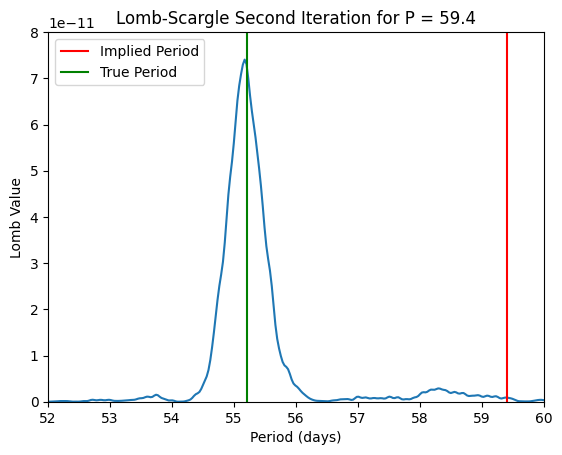

In [237]:
# Code showing incorrect period identification from periodogram, same coding process as Section 2.2
min_time = full_time[1] - full_time[0]
max_time = np.max(full_time) - np.min(full_time)
max_freq = 1 / min_time
min_freq = 1 / max_time
freqs = np.linspace(min_freq,max_freq,50000)
lomb3 = scipy.signal.lombscargle(full_time, full_flux, freqs, precenter=True)
period_new = np.linspace(1,max_time,50000)
lomb4 = scipy.signal.lombscargle(freqs, lomb3, period_new, precenter=True)
plt.plot(period_new, lomb4)
plt.title('Lomb-Scargle Second Iteration for P = 59.4')
plt.ylabel('Lomb Value')
plt.xlabel('Period (days)')
plt.xlim(52,60)
plt.ylim(0,0.8e-10)
plt.axvline(59.4,c='r',label='Implied Period')
plt.axvline(55.2,c='g',label='True Period')
plt.legend()

**Fig. 15.** *Graph showing the location of the high lomb value on the periodogram vs the true period found via extrapolation*.

Text(0.5, 0, 'Phase (Days)')

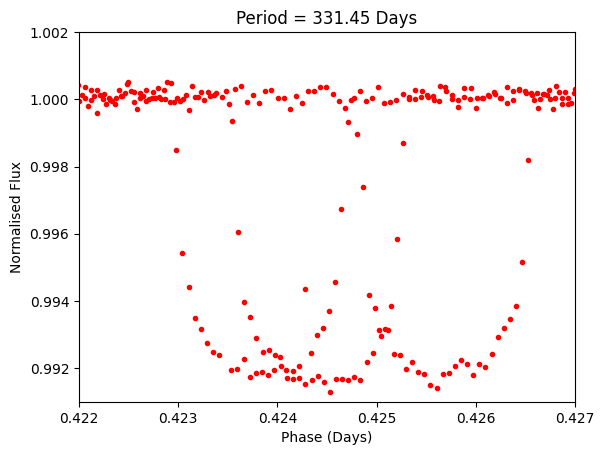

In [239]:
# Lightcurve folding with non-exact period, same coding process as before
P1_new = 331.45
ini_phase1_new, ini_phase_flux1_new, ini_phase_error1_new = fold_lightcurve(full_time, full_flux, full_fluxerror, P1_new)

x_lower1_new, x_upper1_new = (0.422,0.427)
y_lower1_new, y_upper1_new = (0.991,1.002)

plt.plot(ini_phase1_new, ini_phase_flux1_new, ls='None', marker='.', c='red', label='Data')
plt.xlim(x_lower1_new, x_upper1_new)
plt.ylim(y_lower1_new, y_upper1_new)
plt.title('Period = 331.45 Days')
plt.ylabel('Normalised Flux')
plt.xlabel('Phase (Days)')

**Fig. 16.** *Folded light curve at transit location showing asymmetric  folding when folded with non-exact period*.

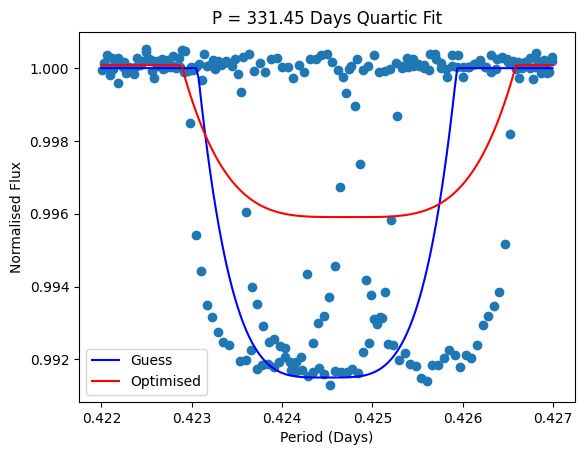

In [240]:
# Code showing incorrect curve fitting from incorrect lightcurve folding, same coding process as before
phase_lims1_new = (ini_phase1_new > x_lower1_new) & (ini_phase1_new < x_upper1_new)
phasemask1_new = phase_lims1_new
phase_new1_new = ini_phase1_new[phasemask1_new]
flux_new1_new = ini_phase_flux1_new[phasemask1_new]
error_new1_new = ini_phase_error1_new[phasemask1_new]
index_sort1_new = np.argsort(phase_new1_new)
phase1_new = phase_new1_new[index_sort1_new]

flux1_new = flux_new1_new[index_sort1_new]
error1_new = error_new1_new[index_sort1_new]

QT_Vals1_new = [1e9,0.4245,-0.0085,1.000]
QT_opt1_new, QT_cov1_new = curve_fit(quartic_transit, phase1_new, flux1_new, p0 = QT_Vals1_new, sigma=error1_new)

plt.plot(phase1_new, flux1_new, ls='None', marker='o')
plt.plot(phase1_new, quartic_transit(phase1_new, *QT_Vals1_new), c='blue', label='Guess')
plt.plot(phase1_new, quartic_transit(phase1_new, *QT_opt1_new), c='red', label='Optimised')
plt.title('P = 331.45 Days Quartic Fit')
plt.ylabel('Normalised Flux')
plt.xlabel('Period (Days)')
plt.legend(loc='best')

**Fig. 17.** *Curve fit function incorrectly fitting the transit due to asymmetric light curve folding*.

### 3. Discussion

The four found planets have been named a,b,c,d within their system named BG-21. The planets will be described using their identifiers: 21a, 21b, 21c, 21d. Below, the metadata for each planet is summarized.

In [241]:
planets_df

,Period [Days],Error (±) [Days],Radius [R_E],Radius [R_J],Error (±) [R_J],Mass [M_E],Mass [M_J],SMA [AU],Error (±) [AU]
Planet Name,,,,,,,,,
21a,331.601,0.021923,12.048365,1.097969,0.046569,381.379772,1.2,0.973766,0.014491
21b,210.607,0.014184,7.519904,0.685290,0.031507,254.253182,0.8,0.719492,0.010707
21c,59.737,0.000861,3.154528,0.287473,0.012697,N/A,N/A,0.310603,0.004622
21d,91.939,0.002159,3.048400,0.277801,0.012553,N/A,N/A,0.414041,0.006161


**Fig. 18.** *The table above summarizes the Exoplanet metadata, in Earth units, Jupiter units and the associated errors in Jupiter units.*

$\textbf{3.1 Model Fitting Comparison}$

In Section 2.4.3 we calculated the reduced chi-squared values for both the Quartic Transit model and the Inverted Bell Curve model. We saw that the QT model outperformed the IBC model for every transit assigned. This is unsurprising as the QT function is almost identical to a exoplanet transit curve. However, we see that for far smaller dips in flux, observed for BG-21c and BG-21d that the IBC reduced chi-squared value is not significantly worse than the QT. For these smaller flux dips, the inverted bell curve models the steady egress and ingress very well. Comparatively, the IBC model is 158% greater than the QT model for the larger BG-21a, whereas 11% greater than the QT model for the smaller BG-21d.

Altogether, an impressive attempt for a function that normally defines Gaussian distributions.

$\textbf{3.2 Exoplanet Comparisons to BG-21 system}$

Below we see comparisons of the four exoplanets found to each other in terms of size in Fig. 17. In blue, we have indicated Earth for reference of relative size. In Fig. 18, we see the planets compared to their host star BG-21 in yellow. Finally, in Fig. 19, we see the relative semi-major axis of the planets. With 21c and 21d orbiting considerably closer to BG-21 than 21a and 21b.

With their sheer relative size, it is unsurprising that 21a and 21b produce such large transit dips, with their transits being visible on even the flattened light curve. Whereas the smaller size of 21c and 21d make for greater difficulty in periodicity identification - as was found in Section 2.2.

In section 2.3 we briefly mentioned the asymmetric folded lightcurve for 21b (P=210.6 Days). Suggesting that the orbital period changes between consecutive transits. This could be a result of gravitational perturbations from the other planets in the system, namely 21a. Nonetheless, this mis-alignment of periodic folding is a limitation of the lightcurve folding method.

We see that the orbital periods are close to being in orbital resonance. With d:c:b:a being close to 2:3:7:11, having ratios 2:3.078:7.051:11.102, calculated using ratios. Typically, these resonances occur in 2:3:4:7:11, suggesting that there may be another planet with a relative resonance of ~4. 

We can estimate the period of this planet; resonances are calculated as follows.

We will name he suggested planet between 21c and 21b as 21x that has to have a resonance ratio of 4. The other four ratios are calculated in a similar way - solving to find the pair of ratio values that equate 1.

$$21d:21c \rightarrow 2:3 \Rightarrow \dfrac{P_{21d}}{P_{21c}}\dfrac{3.078}{2} = \dfrac{59.737}{91.939}\dfrac{3.078}{2} = 1$$

$$21c:21x \rightarrow 3:4 \Rightarrow \dfrac{P_{21c}}{P_{21x}}\dfrac{4}{3.078} = \dfrac{91.939}{P_{21x}}\dfrac{4}{3.078} = 1$$

$$21x:21b \rightarrow 4:7 \Rightarrow \dfrac{P_{21x}}{P_{21b}}\dfrac{7.051}{4} = \dfrac{P_{21x}}{210.607}\dfrac{7.051}{4} = 1$$

$$21b:21a \rightarrow 7:11 \Rightarrow \dfrac{P_{21b}}{P_{21a}}\dfrac{11.102}{7.051} = \dfrac{210.607}{331.601}\dfrac{11.102}{7.051} = 1$$

Therefore, we can estimate $P_{21x}$ as around 120 days assuming it's resonance ratio is exactly 4.

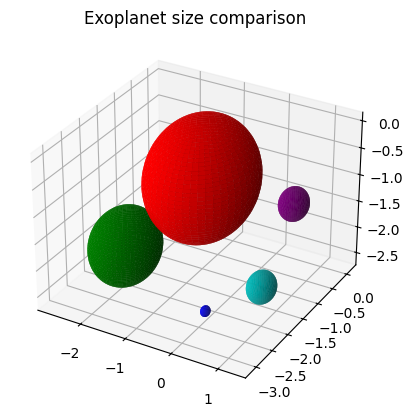

In [285]:
list_center = [(1, 1, 1), (2, 2, 2), (-1, 1, 1), (-1, 2, 2), (-0.5, 3, 2)]
list_radius = R_Jup + [float(R_E_J)]
colour_input = ['r', 'g', 'purple', 'c', 'b']

def plt_sphere(list_center, list_radius, colour_input):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for c, r, color in zip(list_center, list_radius, colour_input):
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x = r * np.cos(u) * np.sin(v)
        y = r * np.sin(u) * np.sin(v)
        z = r * np.cos(v)
        
        # Plot each sphere
        ax.plot_surface(x - c[0], y - c[1], z - c[2], color=color)
    plt.title('Exoplanet size comparison')
    plt.show()

plt_sphere(list_center, list_radius, colour_input)

**Fig. 19.** *3D plot showing the relative sizes of 21a, 21b, 21c, 21d in red, green, purple and cyan respectively. With Earth in blue for comparison.*

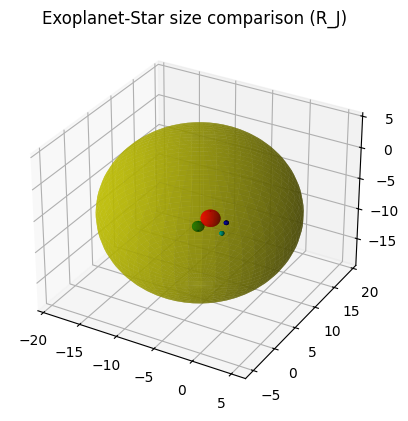

In [287]:
# Size comparison between exoplanets and stars
list_center = [(1, 1, 1), (2, 2, 2), (-1, 1, 1), (-1, 2, 2), (7, -7, 7)]
list_radius = R_Jup + [float(R_s_J)]
colour_input = ['r', 'g', 'b', 'c', 'y']

def plt_sphere(list_center, list_radius, input_color):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for c, r, color in zip(list_center, list_radius, input_color):
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x = r * np.cos(u) * np.sin(v)
        y = r * np.sin(u) * np.sin(v)
        z = r * np.cos(v)

        # Plot each sphere
        ax.plot_surface(x - c[0], y - c[1], z - c[2], color=color, alpha=0.5*np.random.random() + 0.5)
    
    plt.title('Exoplanet-Star size comparison (R_J)')
    plt.show()
    
plt_sphere(list_center, list_radius, colour_input)

**Fig. 20.** *3D plot showing the relative sizes of BG-21, 21a, 21b, 21c, 21d in yellow, red, green, purple and cyan respectively.*

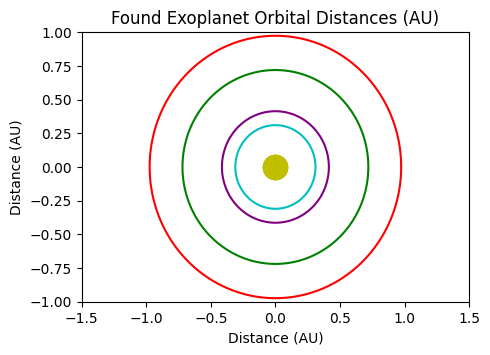

In [307]:
# Orbital distances from the star
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
color_list = ('r', 'green', 'c', 'purple')

plt.figure(figsize=(5,3.5))
for idx in range(len(SMA)):
    F = X**2 + Y**2 - (SMA[idx])**2
    plt.contour(X, Y, F, [0], colors=color_list[idx])
    plt.title('Found Exoplanet Orbital Distances (AU)')
    plt.xlabel('Distance (AU)')
    plt.ylabel('Distance (AU)')
    plt.scatter(0, 0, marker='o', c='y', s=300)

**Fig. 21.** *2D plot showing the relative semi-major axis for 21a, 21b, 21c and 21d around BG-21, in red, green, purple, cyan and yellow respectively.*

$\textbf{3.4 Exoplanet Comparison to wider populations}$

Purely considering relative size, both 21a and 21b are Jupiter size and mass planets, it would be appropriate to assume they are Gas-Giants. Whereas, 21c and 21d are about 3x the radius of Earth, making them comparable to Neptune sized planets (Neptune radius is 3.9x Earth radius). Therefore, most appropriately falling in the class of Mini-Neptunes rather than Super-Earths.

We will now consider the wider population. How do the planetary semi-major axis compare to their masses in the wider population? We will focus on 21a and 21b for this analysis as 21c and 21d have no found masses.

<img src="Mass_AU.jpeg" style="width: 500px;"/>

**Fig. 22.** *Figure illustrating the distribution of Planet Mass in Jupiter masses vs Semi-Major Axis in AU for discovered exoplanets. With 21a indicated in red and 21b in green (credit: NASA Exoplanet Archive)*.

First we notice the significant number of Jupiter mass planets (10^0) orbiting at <0.01 astronomical units. These are known as Hot Jupiters, and the formation of these looked into further in 3.5.2. 21a and 21b are not Hot Jupiters, orbiting at around 1 AU. They reside in the traditional core accretion regime and on the same order of magnitude away from BG-21 as Jupiter is to the Sun (~5AU).

$\textbf{3.5 Science Question: Habitability?}$

$\textbf{3.5.1 Habitable Zone}$

With BG-21 thriving with 4 found planets and possibly more, it's worth asking whether any of these are habitable for humanity. BG-21 is comparable to the Sun at 1.2 Solar Radii, and both stars being Class G with surface temperatures of 6080 K and 5772 K respectively. All planets orbiting within about 1 AU from BG-21 suggest they may reside within the stars habitable zone.

First, we define the habitable zone (or HZ) as the region surrounding the star in which water can remain in it's liquid state. For a sun-like star, expect this to be similar to the Sun's HZ at around 1 AU.

We can verify whether the temperature of these planets at their radii are sufficient to have water at liquid state - 300 K.

Equating the rate of energy radiated by the planet to the rate of energy absorbed by the planet as below.

$$4\pi{}R^{2}\sigma{}T^{4} = \dfrac{\pi{}R^{2}L_{star}(1-a)}{4\pi{}d^{2}} \Rightarrow d = \sqrt{\dfrac{L_{star}(1-a)}{16\pi{}\sigma{}T^{4}}}$$

Where $T$ (K) is temperature at distance $d$ (AU), $L_{star}$ is the luminosity of the star, $\sigma{}$ is the Stefan-Boltzmann constant, and $a$ is the bond albedo which we will take as Jupiter-like for 21a and 21b.

The graph below plots this relation, providing an estimated minimum distance for the HZ between 280 K and 320 K. With an upper and lower bound of temperature using bond albedos of 0.25 and 0.75 - either side of Jupiter's 0.5 albedo.

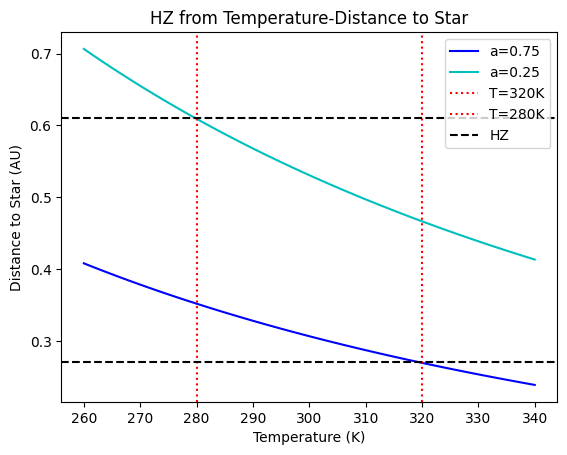

In [318]:
T = np.linspace(260, 340, 100)
d_Upper = (((L_s*(1-0.75))/(16*np.pi*SFC*((T)**4)))**(1/2))/AU
d_Lower = (((L_s*(1-0.25))/(16*np.pi*SFC*((T)**4)))**(1/2))/AU
plt.plot(T, d_Upper, c='b', label='a=0.75'), plt.plot(T, d_Lower, c='c', label='a=0.25')
plt.title('HZ from Temperature-Distance to Star'),plt.ylabel('Distance to Star (AU)'), plt.xlabel('Temperature (K)')
plt.axvline(320, c='r', label='T=320K', ls=':'), plt.axvline(280, c='r', label='T=280K', ls=':')
plt.axhline(0.27, c='black', ls='--', label='HZ'), plt.axhline(0.61, c='black', ls='--')
plt.legend()
plt.show()

**Fig. 23.** *Graph showing the Habitable Zone radii calculated from Equilibrium Temperature, Whitmire et al formulae, and NASA.*

This gives an upper and lower value of the minimum HZ radius as 0.61 AU and 0.27 AU respectively.

We can approximate the radii of the HZ boundaries by using the stellar luminosity in the expression below to a greater accuracy, presented by Whitmire et al.$^{[3]}$

$$ r_{i} = \sqrt{\dfrac{L_{star}}{1.1}}, r_{o} = \sqrt{\dfrac{L_{star}}{0.53}}$$

Where $r_{i}$ and $r_{o}$ denote the inner and outer radii of the HZ boundaries and $L_{star}$ is the stellar luminosity. For BG-21 stellar luminosity of 0.507$L_{Sun}$, this gives the boundaries as 0.68 AU to 0.98 AU.

Alternatively, the NASA Exoplanet Archive provides the HZ radii for BG-21 as 0.9993 AU to 2.3584 AU.$^{[7]}$ This suggests that 21a is approximately at the inner edge of the HZ. 

These three methods to find the HZ form an almost continuous region from 0.27 AU to 2.36 AU.

$\textbf{3.5.2 Planetary Composition}$

Now to consider their compositions - are they rocky planets or gas-giants?. Both planets are significantly larger than the rest of the system, and at Jupiter-like masses, suggesting they could be gas-giants.

Protoplanetary disks are formed during star formation in young stellar systems. Through core accretion or gravitational collapse, the dust in these disks form planets. These clouds consist of mainly Hydrogen and Helium, with some heavier elements forming rocky bodies. Hydrogen and helium are very light and tend to escape smaller bodies with low gravity, however more massive bodies can retain this gas and become large gaseous planets. Hot Jupiters are an exception to this - massive planets orbiting  close to their stars, most likely to have formed via core accretion and migrated inwards.

We can deduce that larger planets will have lower densities than smaller planets as gaseous densities are far lower than rocky densities. The graph below shows this distribution, with jupiter-like gas giants in the upper right and denser earth-like rocky planets in the middle and lower left.

<img src="Mass_Rad.jpeg" style="width: 500px;"/>

**Fig. 24.** *Figure illustrating the distribution of Planet Mass vs Planet Radius in Earth units for discovered exoplanets. With 21a indicated in red and 21b in green (credit: NASA Exoplanet Archive)*.

Therefore, we can safely assume 21a and 21b are gas-giants given their large masses. Although, the planets may not be able to support life due to the gas surface, these giants tend to host many Earth-like habitable moons. So we cannot discredit the possibility of our next Earth being in the HZ of BG-21.

$\textbf{3.6 Future Studies: Atmospheric Composition \& Biosignature?}$

We have discussed the HZ as a way to support liquid water and a high-level view of the planets being gas-giants or rocky earth-like planets. For future studies, the atmospheres of both planets and possible moons would provide greater evidence to the habitability.

This analysis is essential as the atmospheric compositions affect the climate through energy transfer and the greenhouse effect $^{[8]}$. Providing a complete understanding of the planets potential biosignature - an indication of life.

To investigate the planetary atmospheres, there are two approaches. Firstly, transmission photometry of the starlight passing through the planets atmosphere as it transits the star. Secondly, the direct emission from a planets atmosphere by comparing the combined light from the planet and star when it transits and the reduced light during the secondary eclipse.

Phase curves describe the brightness of a reflecting body as a function of it's phase angle. With this, we can investigate the ratio of nitrogen and argon to oxygen, detected by studying thermal phase curves $^{[9]}$ or by transit transmission spectroscopy. 

These curves also provide basis to characterize the planets regolith (soil) and Bond albedo - which would in turn further develop the calculation of the HZ.

Altogether, providing a complete description of the planets possibilities to humanity.

### 4. Summary

$\textbf{4.1 Found Exoplanets}$

$\bullet$ BG-21a, most-likely Gas-Giant: Period, 331.6 (±0.022) Days; Radius, 1.098 (±0.047) Jupiter Radii; Semi-Major Axis, 0.974 (±0.014) AU.

$\bullet$ BG-21b, most-likely Gas-Giant: Period, 210.6 (±0.014) Days; Radius, 0.688 (±0.032) Jupiter Radii; Semi-Major Axis, 0.720 (±0.011) AU.

$\bullet$ BG-21c, most-likely Mini-Neptune: Period, 59.74 (±0.001) Days; Radius, 0.288 (±0.013) Jupiter Radii; Semi-Major Axis, 0.311 (±0.004) AU.

$\bullet$ BG-21d, most-likely Mini-Neptune: Period, 91.94 (±0.002)) Days; Radius, 0.279 (±0.013) Jupiter Radii; Semi-Major Axis, 0.414 (±0.006) AU.

$\textbf{4.2 Orbital Resonance}$

$\bullet$ Orbital periods are close to being in orbital resonance. With d:c:b:a being close to 2:3:7:11, having ratios 2:3.078:7.051:11.102

$\textbf{4.3 Habitability \& Planetary Composition}$

$\bullet$ HZ from equilibrium temperature for liquid water: 0.27 AU to 0.61 AU.

$\bullet$ HZ from Whitmire et Al formulae: 0.68 AU to 0.98 AU.

$\bullet$ HZ from NASA for BG-21: 0.9993 AU to 2.3584 AU

$\bullet$ Three methods to find the HZ form an almost continuous region from 0.27 AU to 2.36 AU. With 21a within the HZ for the majority of sources.

$\bullet$ BG-21 Habitable Zone: Minimum 0.29 AU, Maximum 2.4 AU.

$\bullet$ 21a and 21b most likely to be Gas-Giants, therefore unable to support human life. Though, these planets may have Earth-like moons orbiting them which do reside in the HZ.

$\textbf{4.4 Atmospheric Composition \& Biosignature}$

$\bullet$ Investigate transmission photometry of the starlight passing through the planets atmosphere as it transits the star.


BG-21 is 2840 light years away, which means even when traveling at the speed of light it would still take 2840 years to reach the system. 49 million years traveling at Voyagers speed - perhaps a home for a future humanity.

### References:

$^{[1]}$ - Official Working Definition of an Exoplanet, IAU; 2020
$^{[2]}$ - Schneider, J.; 2021
$^{[3]}$ - Whitmire et al, 1996
$^{[4]}$ - Whittaker, E.; Robinson, G., 1924
$^{[5]}$ - Cdang; 2013
$^{[6]}$ - Lomb, N.R.; 1976, 39, 447
$^{[7]}$ - NASA, Exoplanet Archive Data; 2021
$^{[8]}$ - Catling, D.C; 2015, Abstract
$^{[9]}$ - Selsis, F.; Wordsworth, R.D.; Forget, F.; 2011, 532